# Run network creation in parallel.

Please first start ```ipcluster```, on linux you type the following into the terminal, note that you should be in the ```Snudda/examples/notebook``` directory:

```
export IPYTHONDIR="`pwd`/.ipython"
export IPYTHON_PROFILE=default
ipcluster start 
```

These commands are in ```start_ipcluster.sh``` in the ```examples/notebook``` directory. After starting ipcluster give it a few seconds to get fully up and running before proceeding with the rest of the commands in this notebook. 

If you restart the run you might need to do:

```
ipcluster stop
ipcluster start
```

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel


The instructions above are created on Linux. If you run on **Windows** and do not get the environment variables to work for ipcluster, then you might need to update ```IPYTHONDIR``` in cell 1, and ```u_file``` in cell 3 to point to the location that ipcluster writes the pid file to.

In [1]:
import os
from snudda import SnuddaInit

network_path = os.path.join("networks","simple_example_parallel")
si = SnuddaInit(struct_def={}, network_path=network_path, random_seed=123)
si.define_striatum(num_dSPN=200, num_iSPN=200, num_FS=4, num_LTS=0, num_ChIN=0,
                    volume_type="cube", neurons_dir="$DATA/neurons")
si.write_json()

Using cube for striatum
Adding neurons: FSN from dir $DATA/neurons/striatum/fs
Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing networks/simple_example_parallel/network-config.json


In [2]:
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(os.getcwd(), ".ipython", "profile_default", "security", 
                      "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Passing valid rc parameter to SnuddaDetect will lead to parallel execution.
When we use network_path as parameter we assume the config file is located in that directory and that it is named ```network-config.json```

In [3]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, rc=rc)
sp.place()

In [4]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc)
sd.detect()

importing SnuddaDetect from snudda.detect.detect on engine(s)
Suppressing printouts for hyper voxels that complete in < 100 seconds.


In the folder ```networks/simple_example_parallel/log/``` you can find log files for touch detection. The file ```touch-detection.txt``` is the master node log, and the files ```touch-detection.txt-0``` up to ```n``` are the different worker logs where you can see what they are doing, since they do not print their output to stdout.

In [5]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc)
sp.prune()

importing SnuddaPrune from snudda.detect.prune on engine(s)
prune_synapses_parallel (81681/1427462 synapses, 5.7% kept): 2.0s
prune_synapses_parallel (8/15 gapJunctions, 53.3% kept): 0.1s


Loading 404 neurons with 81681 synapses and 8 gap junctions


/home/hjorth/HBP/Snudda/snudda/plotting/plot_network.py:41: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


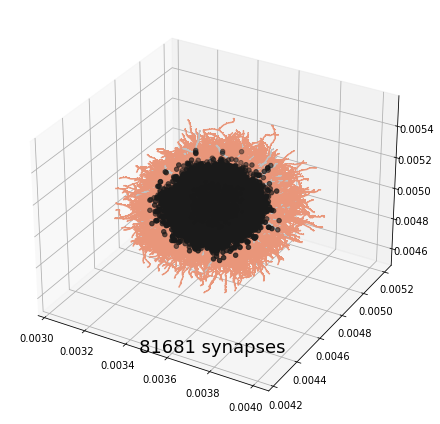

In [6]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-synapses.hdf5")
pn = PlotNetwork(network_file)
pn.plot()
pn.close()  # Close the hdf5 file so others can use it